In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e7/sample_submission.csv
/kaggle/input/playground-series-s5e7/train.csv
/kaggle/input/playground-series-s5e7/test.csv


Please consider upvoting this notebook

In [2]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [3]:
train = pd.read_csv("/kaggle/input/playground-series-s5e7/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s5e7/test.csv")

In [4]:
train.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert
3,3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert
4,4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert


In [5]:
print("Train Shape :", train.shape)
print("Test Shape :",test.shape)

Train Shape : (18524, 9)
Test Shape : (6175, 8)


In [6]:
train.columns

Index(['id', 'Time_spent_Alone', 'Stage_fear', 'Social_event_attendance',
       'Going_outside', 'Drained_after_socializing', 'Friends_circle_size',
       'Post_frequency', 'Personality'],
      dtype='object')

In [7]:
print ("\nMissing values :  ", train.isnull().sum().values.sum())


Missing values :   9196


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18524 entries, 0 to 18523
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         18524 non-null  int64  
 1   Time_spent_Alone           17334 non-null  float64
 2   Stage_fear                 16631 non-null  object 
 3   Social_event_attendance    17344 non-null  float64
 4   Going_outside              17058 non-null  float64
 5   Drained_after_socializing  17375 non-null  object 
 6   Friends_circle_size        17470 non-null  float64
 7   Post_frequency             17260 non-null  float64
 8   Personality                18524 non-null  object 
dtypes: float64(5), int64(1), object(3)
memory usage: 1.3+ MB


In [9]:
((train.isnull().sum())*100)/train.shape[0]

id                            0.000000
Time_spent_Alone              6.424098
Stage_fear                   10.219175
Social_event_attendance       6.370114
Going_outside                 7.914057
Drained_after_socializing     6.202764
Friends_circle_size           5.689916
Post_frequency                6.823580
Personality                   0.000000
dtype: float64

In [10]:
print("Unique Values : \n", train.nunique())

Unique Values : 
 id                           18524
Time_spent_Alone                12
Stage_fear                       2
Social_event_attendance         11
Going_outside                    8
Drained_after_socializing        2
Friends_circle_size             16
Post_frequency                  11
Personality                      2
dtype: int64


In [11]:
train['Time_spent_Alone'].unique()

array([ 0.,  1.,  6.,  3.,  2.,  4., nan,  5.,  9., 10.,  7.,  8., 11.])

In [12]:
for col in train.columns:
    print(f"Unique values in {col} :", train[col].unique())

Unique values in id : [    0     1     2 ... 18521 18522 18523]
Unique values in Time_spent_Alone : [ 0.  1.  6.  3.  2.  4. nan  5.  9. 10.  7.  8. 11.]
Unique values in Stage_fear : ['No' 'Yes' nan]
Unique values in Social_event_attendance : [ 6.  7.  1.  4.  8.  2.  5. nan  0.  9.  3. 10.]
Unique values in Going_outside : [ 4.  3.  0.  5. nan  1.  6.  2.  7.]
Unique values in Drained_after_socializing : ['No' nan 'Yes']
Unique values in Friends_circle_size : [15. 10.  3. 11. 13. nan  4.  0. 14.  5.  9. 12.  8.  2.  1.  6.  7.]
Unique values in Post_frequency : [ 5.  8.  0. nan  3.  4.  2.  9. 10.  6.  7.  1.]
Unique values in Personality : ['Extrovert' 'Introvert']


In [13]:
mean = train['Time_spent_Alone'].mean()
train['Time_spent_Alone'] = train['Time_spent_Alone'].fillna(mean)

In [14]:
numeric_cols = ['Time_spent_Alone', 'Social_event_attendance', 'Going_outside',
                'Friends_circle_size', 'Post_frequency']
binary_cols = ['Stage_fear', 'Drained_after_socializing']

In [15]:
test.isnull().sum()

id                             0
Time_spent_Alone             425
Stage_fear                   598
Social_event_attendance      397
Going_outside                466
Drained_after_socializing    432
Friends_circle_size          350
Post_frequency               408
dtype: int64

In [16]:
for col in numeric_cols:
    train.fillna({col: train[col].mean()}, inplace=True)
    test.fillna({col: train[col].mean()}, inplace=True)

In [17]:
for col in binary_cols:
    mode = train[col].mode()[0]
    train.fillna({col : mode}, inplace = True)
    test.fillna({col:mode},inplace = True)
    # Convert Yes/No to 1/0
    train[col] = train[col].map({'Yes': 1, 'No': 0})
    test[col] = test[col].map({'Yes': 1, 'No': 0})

In [18]:
train.head(3)

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,0,0.0,0,6.0,4.0,0,15.0,5.0,Extrovert
1,1,1.0,0,7.0,3.0,0,10.0,8.0,Extrovert
2,2,6.0,1,1.0,0.0,0,3.0,0.0,Introvert


In [19]:
le = LabelEncoder()
train['Personality'] = le.fit_transform(train['Personality'])  # Extrovert → 0, Introvert → 1

In [20]:
train.columns

Index(['id', 'Time_spent_Alone', 'Stage_fear', 'Social_event_attendance',
       'Going_outside', 'Drained_after_socializing', 'Friends_circle_size',
       'Post_frequency', 'Personality'],
      dtype='object')

In [21]:
features = ['Time_spent_Alone', 'Stage_fear', 'Social_event_attendance',
       'Going_outside', 'Drained_after_socializing', 'Friends_circle_size',
       'Post_frequency']
X = train[features]
y = train['Personality']

In [22]:
X.head(3)

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency
0,0.0,0,6.0,4.0,0,15.0,5.0
1,1.0,0,7.0,3.0,0,10.0,8.0
2,6.0,1,1.0,0.0,0,3.0,0.0


In [23]:
y.head(3)

0    0
1    0
2    1
Name: Personality, dtype: int64

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    X,y,
    test_size = 0.2,
    random_state = 42
)

In [25]:
model = RandomForestClassifier(random_state = 42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [26]:
y_pred = model.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [27]:
val_accuracy = accuracy_score(y_test, y_pred)
print(f"Validation Accuracy: {val_accuracy:.7f}")

Validation Accuracy: 0.9668016


In [28]:
test_preds = model.predict(test[features])
test_preds

array([0, 1, 0, ..., 0, 0, 1])

In [29]:
test['Personality'] = le.inverse_transform(test_preds)
test['Personality']

0       Extrovert
1       Introvert
2       Extrovert
3       Extrovert
4       Introvert
          ...    
6170    Extrovert
6171    Introvert
6172    Extrovert
6173    Extrovert
6174    Introvert
Name: Personality, Length: 6175, dtype: object

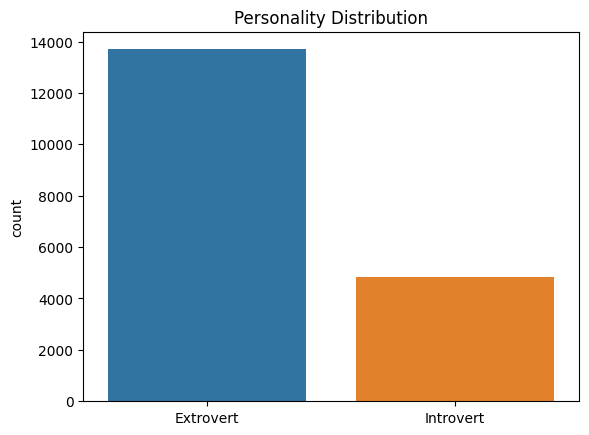

In [30]:
sns.countplot(data=train, x=le.inverse_transform(y))
plt.title("Personality Distribution")
plt.show()

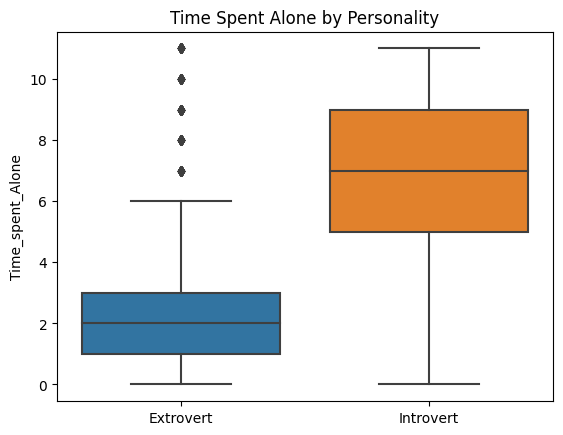

In [31]:
sns.boxplot(data=train, x=le.inverse_transform(y), y='Time_spent_Alone')
plt.title("Time Spent Alone by Personality")
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

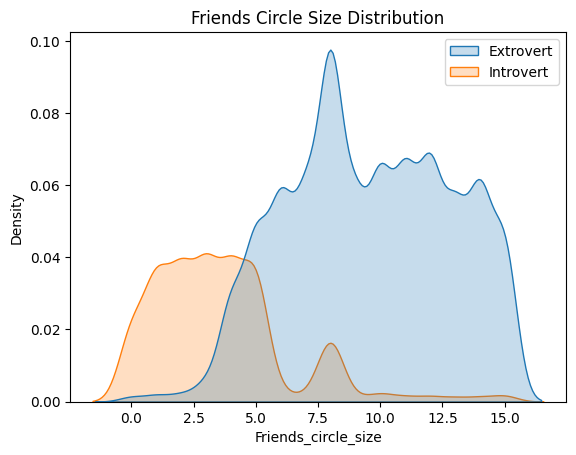

In [32]:
sns.kdeplot(data=train, x='Friends_circle_size', hue=le.inverse_transform(y), fill=True)
plt.title("Friends Circle Size Distribution")
plt.show()

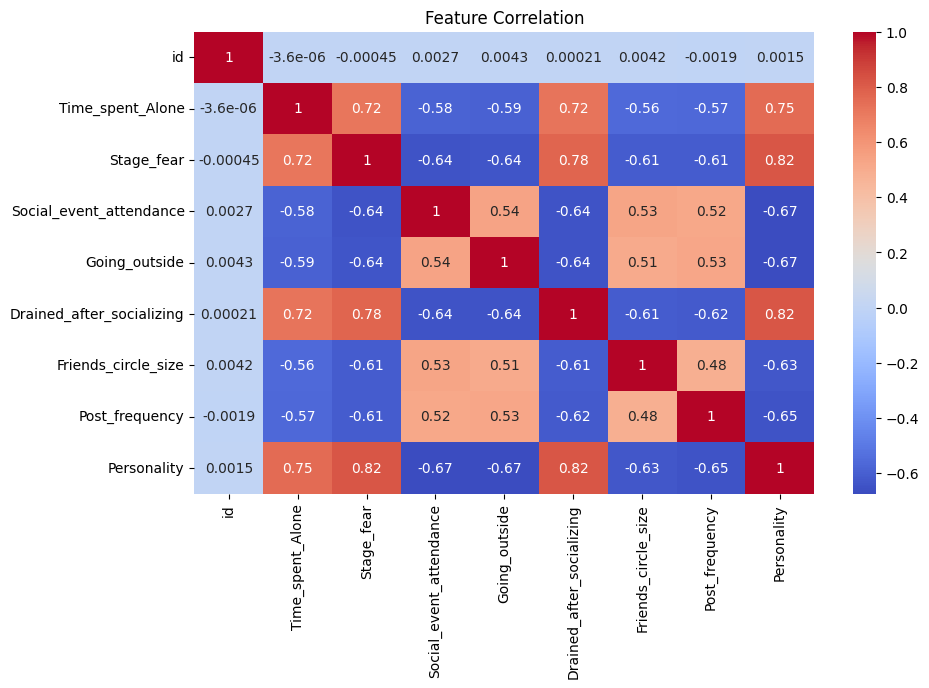

In [33]:
train_corr = train.copy()
plt.figure(figsize=(10, 6))
sns.heatmap(train_corr.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation")
plt.show()

In [34]:
test_preds = model.predict(test[features])
test['Personality'] = le.inverse_transform(test_preds)  # convert back to string labels

In [35]:
submission = test[['id', 'Personality']]
submission.to_csv("submission2.csv", index=False)
print("submission.csv ready to upload!")

submission.csv ready to upload!
